# Objective
## The aim of this notebook is to estimate the T1,T2 values of the subject 2 using the dicitonary method

In [20]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from multiprocessing import Pool
%matplotlib inline

In [21]:
pics_out1 = np.load('subject2/pics_out_96ETL_experimental_data.npy')
print(pics_out1.shape)

(288, 288, 96)


Text(0.5, 1.0, 'Echo number: ')

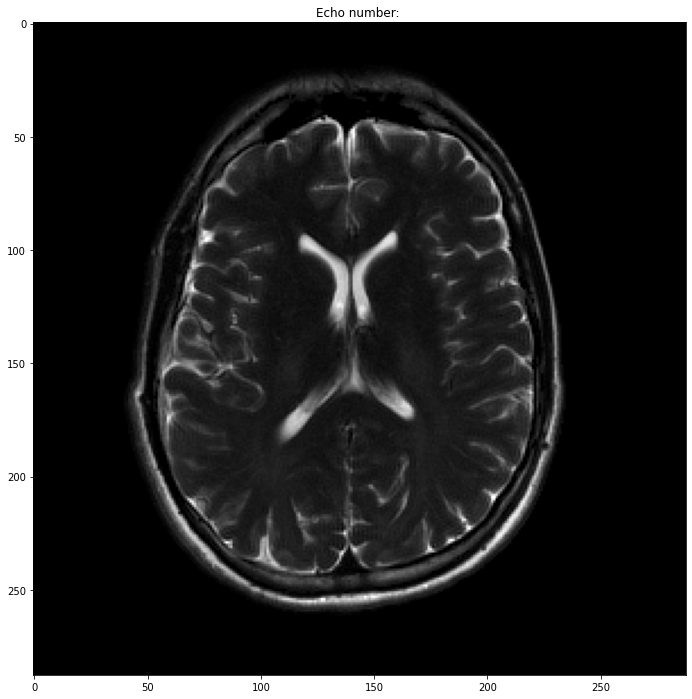

In [25]:
# TR = [860,1830,2800], ETL = 32
plt.figure(figsize=(16,12))
plt.imshow(np.abs(pics_out1[:,:,90]), cmap='gray',vmax = .0003,vmin=0)
plt.title('Echo number: ')

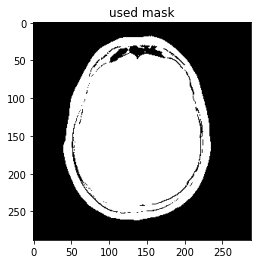

mask shape:  (288, 288)


In [3]:
mask = (np.abs(pics_out1[:,:,0+32*2]) > 0.00007)*1 #mask of brain where the actual images is present
plt.imshow(mask, cmap='gray')
plt.title('used mask')
plt.show()
print('mask shape: ',np.shape((mask)))

In [26]:
ETL = pics_out1.shape[2]
pics_out = np.zeros(pics_out1.shape, dtype=complex)
signal_evolution = np.zeros((35818,pics_out1.shape[2]), dtype=complex)#only calculating for the mask

for index in range(ETL):
    Im_synthetic = np.zeros([pics_out1.shape[0],pics_out1.shape[1]], dtype=complex)
    data = pics_out1[:,:,index]
    Im_synthetic[np.nonzero(mask)]  = data[np.nonzero(mask)] 
    pics_out[:,:,index] = Im_synthetic
    signal_evolution[:,index] = Im_synthetic[np.nonzero(mask)]
    
    
print(signal_evolution.shape)

(35818, 96)


In [5]:
signal_evolution = signal_evolution[:,1::2]
print(signal_evolution.shape)

(35818, 48)


## Dictionary method with standard numpy definitions as done last time, this is slow so maybe move to torch definitions and gpu computing

In [6]:
t1_min = 100
t1_max = 6000
t2_min = 10
t2_max = 1000
N_t1 = 300
N_t2 = 550

#number of parrallel processes to run, depends upon the number of CPU that we have
import multiprocessing
print("Number of cpu : ", multiprocessing.cpu_count())
par_jobs = multiprocessing.cpu_count()


t1_vals = np.round(np.linspace(t1_min, t1_max, N_t1))
t2_vals = np.round(np.linspace(t2_min, t2_max, N_t2))

print('T1 step:', t1_vals[1] - t1_vals[0], 'ms')
print('T2 step:', t2_vals[1] - t2_vals[0], 'ms')

_t1_vals, _t2_vals = np.meshgrid(t1_vals, t2_vals)
_t1_t2_vals = np.stack((_t1_vals.ravel(), _t2_vals.ravel()), axis=1)
_idxs = _t1_t2_vals[:,0] >= _t1_t2_vals[:,1]
t1_t2_vals = _t1_t2_vals[_idxs,:]
print(t1_t2_vals.shape)

Number of cpu :  32
T1 step: 20.0 ms
T2 step: 2.0 ms
(153356, 2)


In [7]:
import sys#this helps with reading data from multiple places
sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
sys.path.insert(0, 'bart/python')#do we need bart here right now
sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function

import t1t2shuffle as t2sh
import epg

def myfun(t1t2):
    sig_dict = {
        'T1': t1t2[0],
        'T2': t1t2[1],
    }
    TR_vals = np.array([860, 1830, 2800])
    TRs = TR_vals
    N_TRs = 3#number of reptitions to get the T1 weighting
    TE = 9.1*2
    ETL = 16
    angles_rad = np.ones((ETL))*180*np.pi/180
    #update the code for stopping the driven equil case
    signal = t2sh.t1t2shuffle2(angles_rad, TE, TRs, 1, T1= sig_dict['T1'], T2 = sig_dict['T2'], driven_equil = False, fr_sign = False)
    return signal/np.linalg.norm(signal)

In [8]:
with Pool(par_jobs) as p:
    result_dict = list((tqdm(p.imap(myfun, t1_t2_vals), total=len(t1_t2_vals), leave=True)))

In [9]:
def dictionary_match(y_sig, Dict, t1t2_list):
    
    # get best match
    z = np.dot(Dict, y_sig)
    #z = np.dot(Dict, y_sig/np.max(y_sig))
    i = np.argmax(np.abs(z))
    
    # get scaling
    # sc = z[i] / sc_list[i]
    
    return z[i], t1t2_list[i,:], i#, sc

In [10]:
def _dictionary_match(y):
    return dictionary_match(y, result_dict, t1_t2_vals)

with Pool(par_jobs) as p:
    result_map = list((tqdm(p.imap(_dictionary_match, np.abs(signal_evolution)), total=len(signal_evolution), leave=True,desc="Doing dictionary matching")))


In [11]:
# reading the output of dictionary match
X_map = np.array(result_map).T
T1_T2_index = X_map[2,:].astype(int)
#print(T1_T2_index)
#print(t1_t2_vals[T1_T2_index,:])

In [12]:
T1_values = t1_t2_vals[T1_T2_index,0]
T2_values = t1_t2_vals[T1_T2_index,1]
PD_values = X_map[0,:]

In [13]:
Im_synthetic1 = np.zeros([pics_out1.shape[0],pics_out1.shape[1]])
Im_synthetic1[np.nonzero(mask)]  = t1_t2_vals[T1_T2_index,0]

Im_synthetic2 = np.zeros([pics_out1.shape[0],pics_out1.shape[1]])
Im_synthetic2[np.nonzero(mask)]  = t1_t2_vals[T1_T2_index,1]

Im_synthetic3 = np.zeros([pics_out1.shape[0],pics_out1.shape[1]])
Im_synthetic3[np.nonzero(mask)]  = PD_values

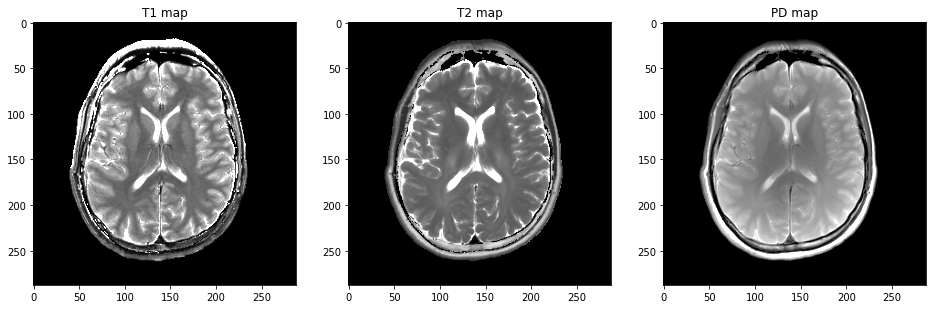

In [14]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(Im_synthetic1, cmap='gray',vmax = 2000,vmin=0)
plt.title('T1 map')

plt.subplot(1,3,2)
plt.imshow(Im_synthetic2, cmap='gray',vmax = 200,vmin=10)
plt.title('T2 map')

plt.subplot(1,3,3)
plt.imshow(Im_synthetic3, cmap='gray',vmax = .0015,vmin=0)
plt.title('PD map')

plt.show()

In [15]:
# # #to save the relevant maps

np.save('subject2/Subject2_T2_vals_experimental.npy',T2_values)#saving the experimental evaluated T2 values
np.save('subject2/Subject2_T1_vals_experimental.npy',T1_values)
np.save('subject2/Subject2_mask_experimental.npy',mask)
np.save('subject2/Subject2_PD.npy',Im_synthetic3)
#np.save('Dictoinary_signal_evol.npy',Dictionary)

In [17]:
T1T2_vals = np.load('T1T2_vals.npy')#load the T1,T2 value matrix of subject 0 recorded days earlier
print(T1T2_vals.shape)

(2, 30137)


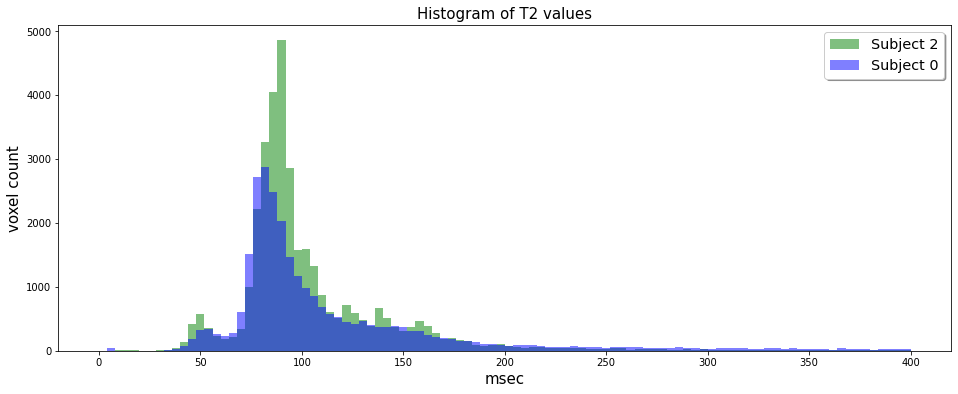

Only even echoes


In [18]:
plt.figure(figsize=(16, 6))
plt.hist(T2_values[T2_values<400], 100, range=[0, 400], facecolor='green', align='mid', label = 'Subject 2', alpha = 0.5)
#plt.title('Histogram of T2_values (Our data)',fontsize=15)
#plt.xlabel('msec',fontsize=15)
# plt.show()

t2_truncated = T1T2_vals[1,:]

# plt.figure(figsize=(16, 6))
plt.hist(t2_truncated[t2_truncated<400], 100, range=[0, 400], facecolor='blue', align='mid', label = 'Subject 0', alpha = 0.5)
plt.title('Histogram of T2 values',fontsize=15)
plt.xlabel('msec',fontsize=15)
plt.ylabel('voxel count',fontsize=15)
plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()
print('Only even echoes')

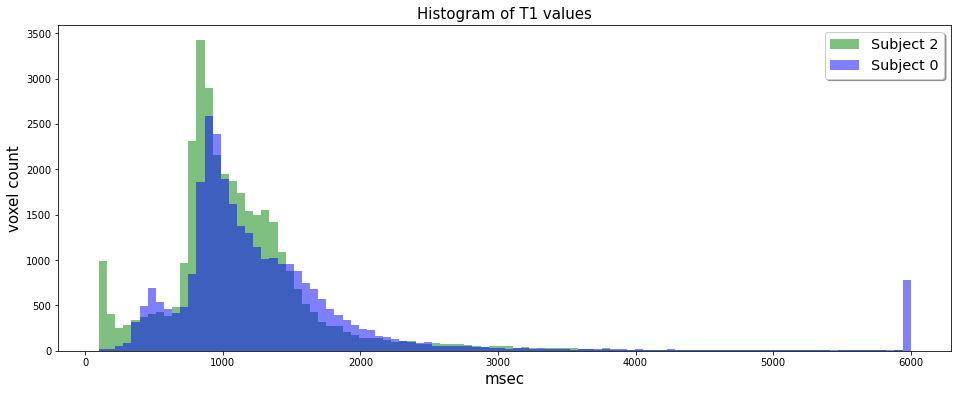

Only even echoes


In [19]:
plt.figure(figsize=(16, 6))
plt.hist(T1_values[T1_values<6000], 100, range=[100, 6000], facecolor='green', align='mid', label = 'Subject 2', alpha = 0.5)

t1_truncated = T1T2_vals[0,:]
plt.hist(t1_truncated[t1_truncated<8000], 100, range=[100, 6000], facecolor='blue', alpha = 0.5, align='mid', label = 'Subject 0')
plt.title('Histogram of T1 values',fontsize=15)
plt.xlabel('msec',fontsize=15)
plt.ylabel('voxel count',fontsize=15)
plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()
print('Only even echoes')